In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import scvi
from scipy.stats import median_abs_deviation

Global seed set to 0
C:\Users\Fabricio S. da Costa\miniconda3\envs\singlecell\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
pip install scikit-misc

Note: you may need to restart the kernel to use updated packages.


In [2]:
adata = sc.read_h5ad("C:/Users/Fabricio S. da Costa/OneDrive/Área de Trabalho/IC/Projetos Singlecell/Atlas Pulmão/Zhang/Epithelium/epithelium.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 12167 × 24292
    obs: 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'barcode', 'cell_type'

In [4]:
adata.obs

nCount_RNA  nFeature_RNA patient_id             barcode  \
barcode                                                                       
BD_immune01_612637       45924          7202   immune01  BD_immune01_612637   
BD_immune01_698718       41596          7356   immune01  BD_immune01_698718   
BD_immune01_509246       31883          6346   immune01  BD_immune01_509246   
BD_immune01_101435       31458          6632   immune01  BD_immune01_101435   
BD_immune01_216465        4737          2552   immune01  BD_immune01_216465   
...                        ...           ...        ...                 ...   
BD_immune09_272379       23480          4690   immune09  BD_immune09_272379   
BD_immune09_6732         21081          4147   immune09    BD_immune09_6732   
BD_immune09_311353       18064          4212   immune09  BD_immune09_311353   
BD_immune04_166127        2091          1080   immune04  BD_immune04_166127   
BD_immune10_84360         4457          1745   immune10   BD_immune10_84360   

                           cell_type  
barcode                               
BD_immune01_612637  Epithelial cells  
BD_immune01_698718  Epithelial cells  
BD_immune01_509246  Epithelial cells  
BD_immune01_101435  Epithelial cells  
BD_immune01_216465  Epithelial cells  
...                              ...  
BD_immune09_272379  Epithelial cells  
BD_immune09_6732    Epithelial cells  
BD_immune09_311353  Epithelial cells  
BD_immune04_166127  Epithelial cells  
BD_immune10_84360   Epithelial cells  

[12167 rows x 5 columns]

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=20)

In [6]:
adata.shape

(12167, 21583)

In [7]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

In [8]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=[20], log1p=True, inplace=True)

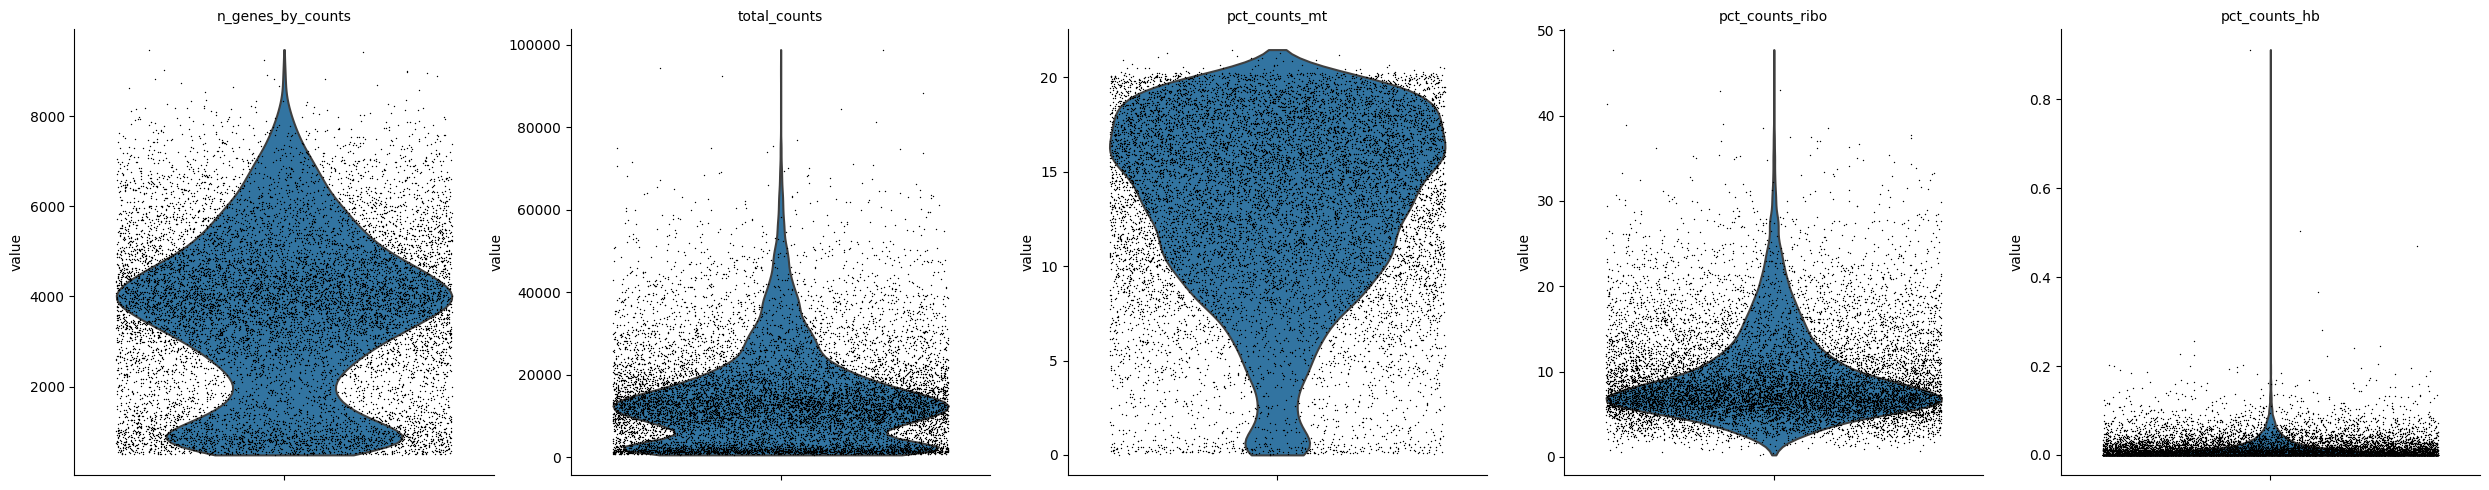

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, multi_panel=True)

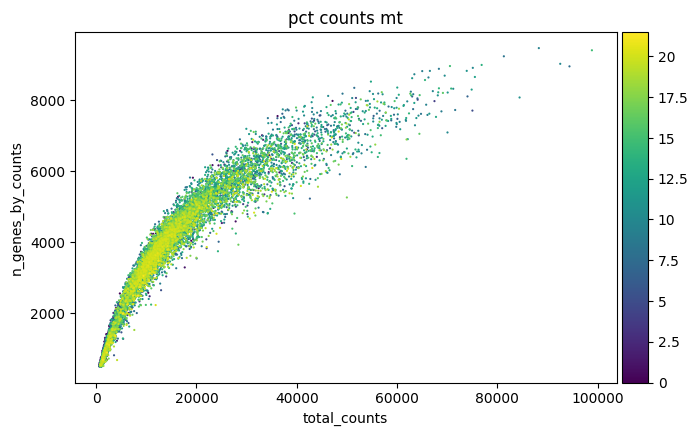

In [10]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", color_map='viridis')

In [11]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [12]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    10922
True      1245
Name: count, dtype: int64

In [13]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 30
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    11511
True       656
Name: count, dtype: int64

In [14]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 12167
Number of cells after filtering of low quality cells: 10373


In [15]:
adata.layers['counts'] = adata.X.copy()

In [17]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [18]:
# Cell cycle
cell_cycle_genes = [x.strip() for x in open('C:/Users/Fabricio S. da Costa/OneDrive/Área de Trabalho/IC/Arquivos úteis/CellCycleGenes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
adata.obs["cell_cycle_diff"] = adata.obs["S_score"] - adata.obs["G2M_score"]

In [19]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=3000, layer='counts', subset=True)

In [20]:
scvi.model.SCVI.setup_anndata(adata, batch_key="patient_id", layer="counts")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [21]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

vae = scvi.model.SCVI(adata, **arches_params)
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|███████████████████████████████████████| 400/400 [2:45:18<00:00, 19.18s/it, loss=1.52e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████| 400/400 [2:45:18<00:00, 24.80s/it, loss=1.52e+03, v_num=1]


In [22]:
adata.obsm["X_scVI"] = vae.get_latent_representation()
adata.layers['scvi_normalized'] = vae.get_normalized_expression(library_size = 1e4)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

C:\Users\Fabricio S. da Costa\miniconda3\envs\singlecell\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Fabricio S. da Costa\miniconda3\envs\singlecell\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Fabricio S. da Costa\miniconda3\envs\si

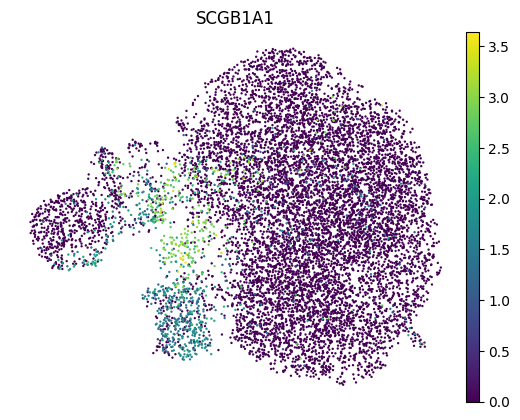

In [66]:
sc.pl.umap(adata, color = ['SCGB1A1'], frameon=False, ncols = 3)

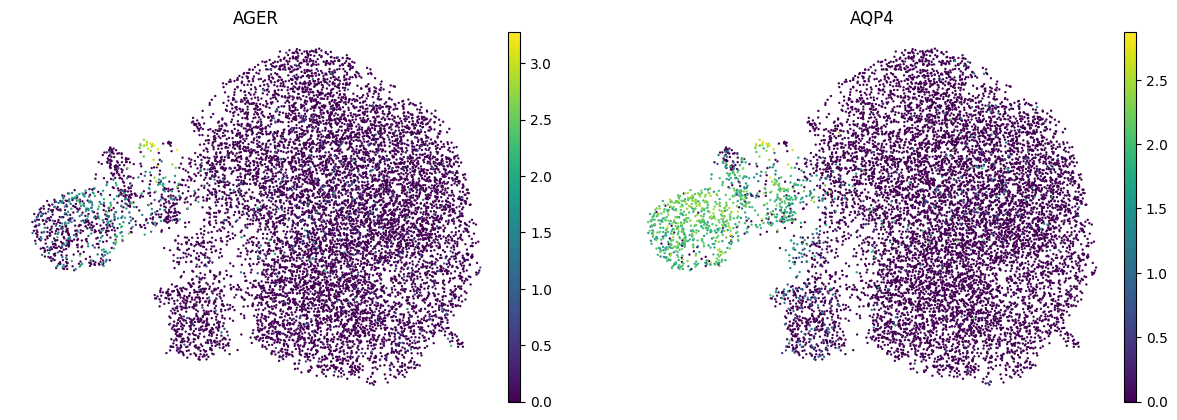

In [63]:
sc.pl.umap(adata, color = ['AGER', 'AQP4'], frameon=False, ncols = 3)

In [48]:
marker_genes = {
'AT1 cells': ['AGER', 'AQP4'], 
'AT2 cells': ['SFTPA1', 'SFTPA2', 'SFTPB'], 
'Ciliated Cells': ['FOXJ1', 'HYDIN'], 
'Club Cells': ['SCGB3A1', 'SCGB3A2'], 
'Malignant Cells': ['KRT5', 'KRT17'], 
}

In [49]:
marker_genes_in_data = dict()
for ct, markers in marker_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in adata.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

In [50]:
Epithelial_cts = [
    "AT1 cells",
    "AT2 cells",
    "Ciliated Cells",
    "Club Cells",
    "Malignant Cells",
]

AT1 CELLS:


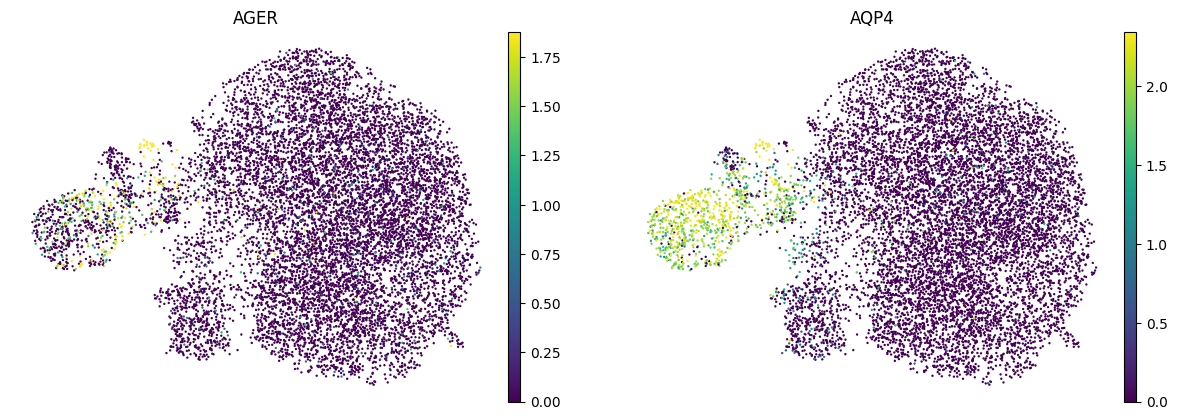





AT2 CELLS:


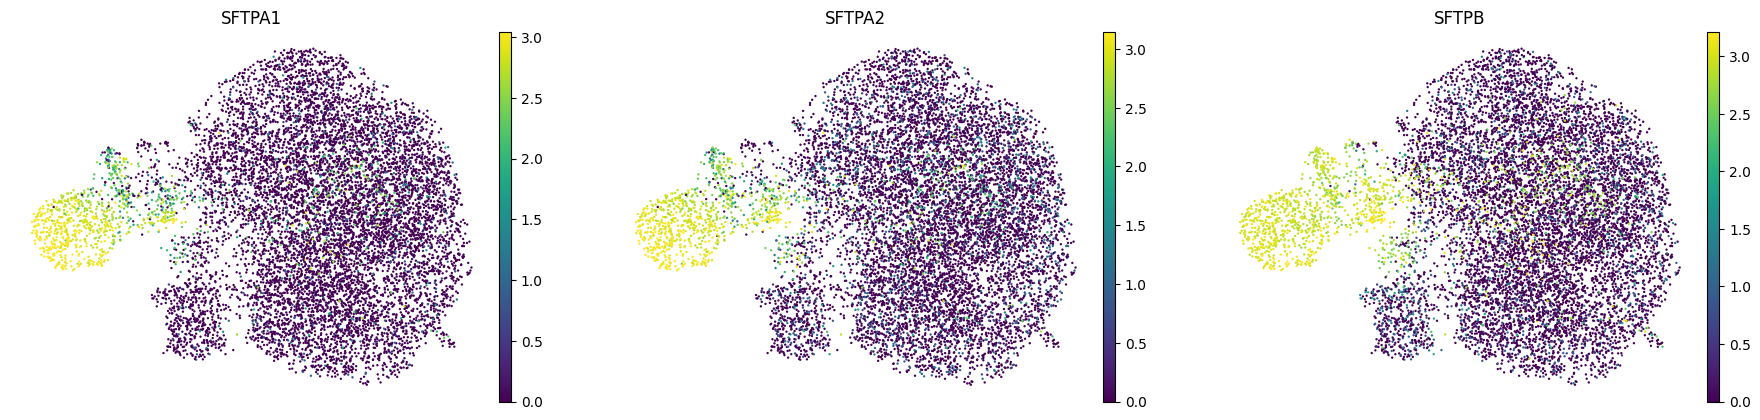





CILIATED CELLS:


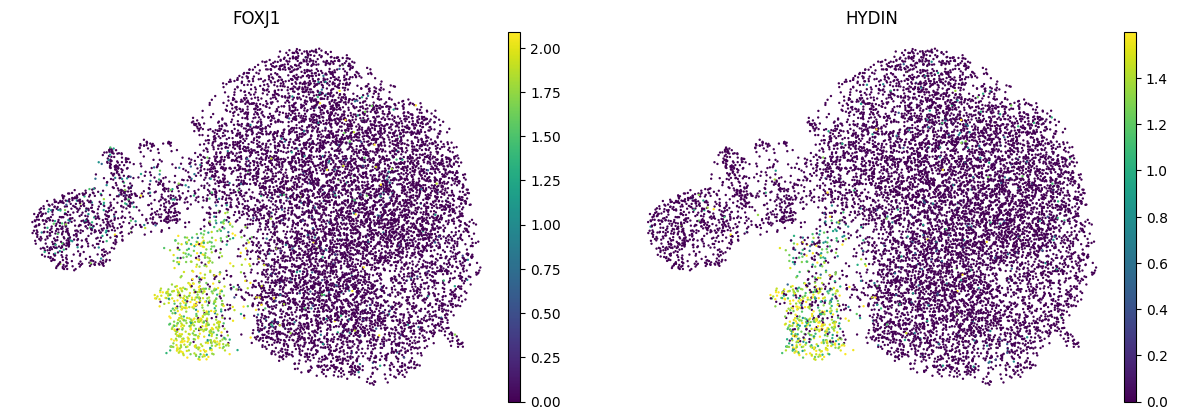





CLUB CELLS:


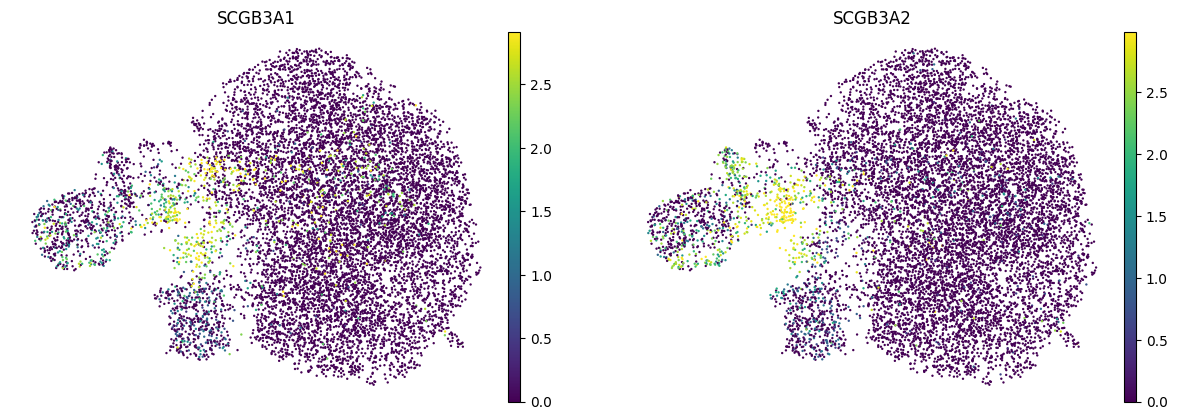





MALIGNANT CELLS:


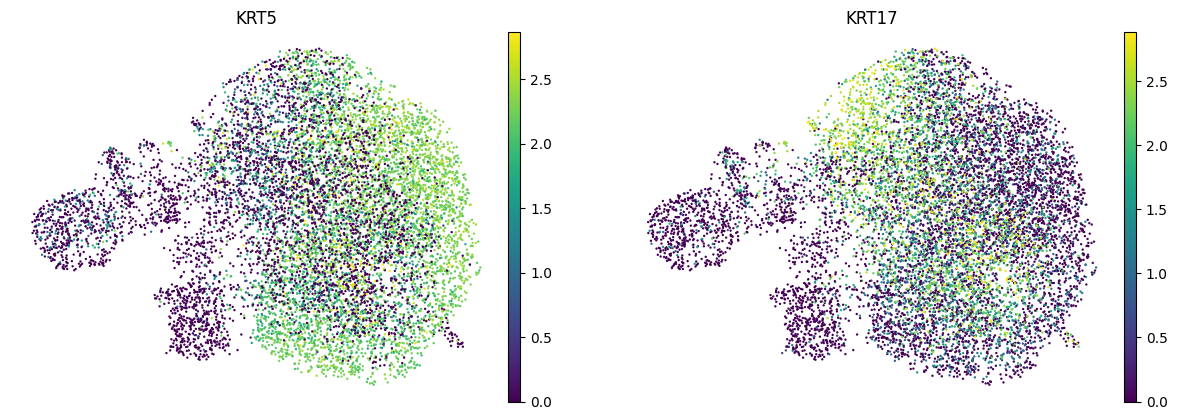

In [58]:
for ct in Epithelial_cts:
    print(f"{ct.upper()}:")  # print cell subtype name
    sc.pl.umap(
        adata,
        color=marker_genes_in_data[ct],
        vmin=0,
        vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=False,
        cmap="viridis",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    )
    print("\n\n\n")  # print white space for legibility

In [31]:
for resolution in [0.5, 1.0, 1.5]:
    sc.tl.leiden(adata, resolution=resolution, key_added=f"leiden_r{resolution}", random_state=0)

C:\Users\Fabricio S. da Costa\miniconda3\envs\singlecell\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\Fabricio S. da Costa\miniconda3\envs\singlecell\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\Fabricio S. da Costa\miniconda3\envs\singlecell\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


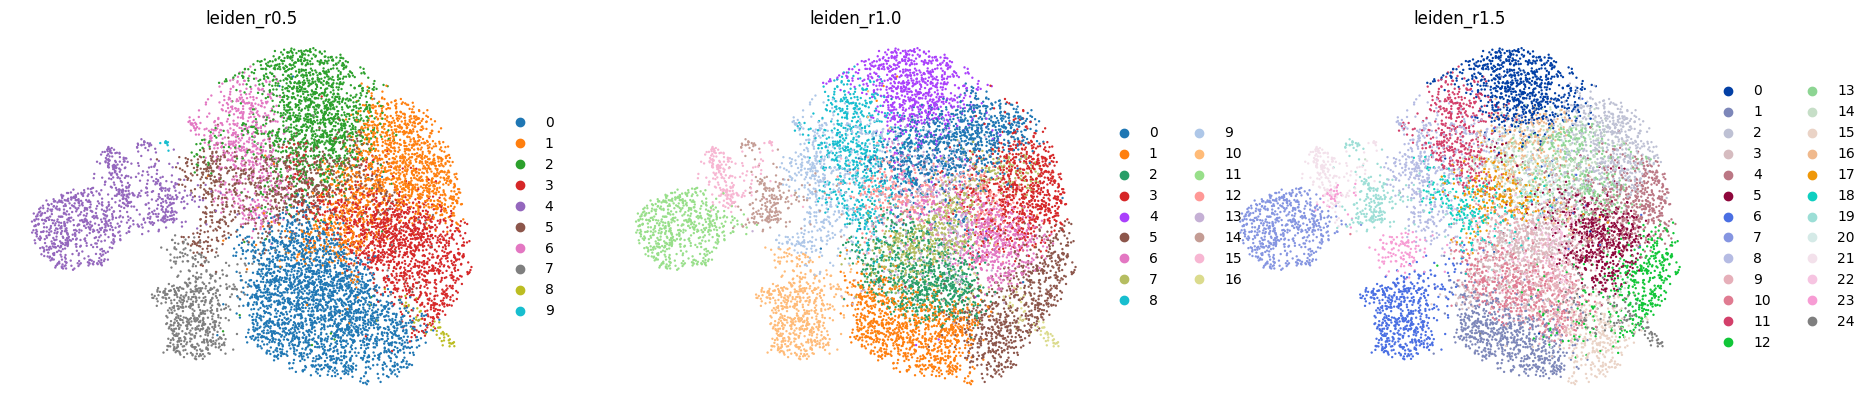

In [32]:
sc.pl.umap(adata, color=['leiden_r0.5', 'leiden_r1.0', 'leiden_r1.5'], frameon=False, ncols=3)

C:\Users\Fabricio S. da Costa\miniconda3\envs\singlecell\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


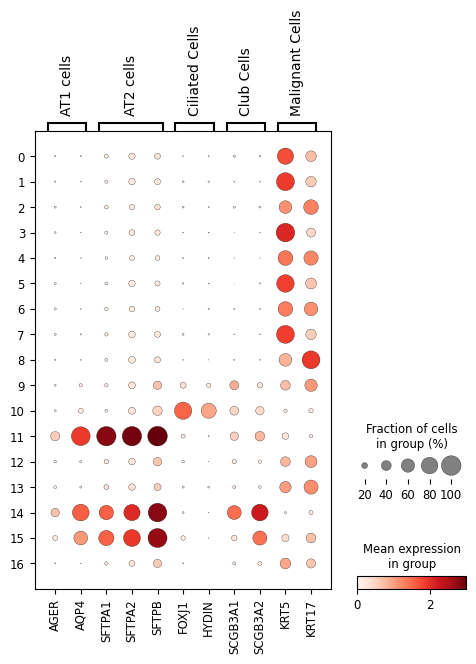

In [61]:
sc.pl.dotplot(adata, marker_genes, 'leiden_r1.0', dendrogram=False)

In [59]:
cell_label = {'Malignant Cells':['0', '1', '2', '3', '4', '5', '6', '7', '8', '12', '13', '16'],
                 'Club Cells':['9'], 
                 'Ciliated Cells':['10'],
                 'AT1 Cells':['14'],
                 'AT2 Cells': ['15', '11']
}

adata.obs['cell_type'] = np.nan

for i in cell_label.keys():
    ind = pd.Series(adata.obs['leiden_r1.0']).isin(cell_label[i])
    adata.obs.loc[ind, 'cell_type']=i

C:\Users\Fabricio S. da Costa\miniconda3\envs\singlecell\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


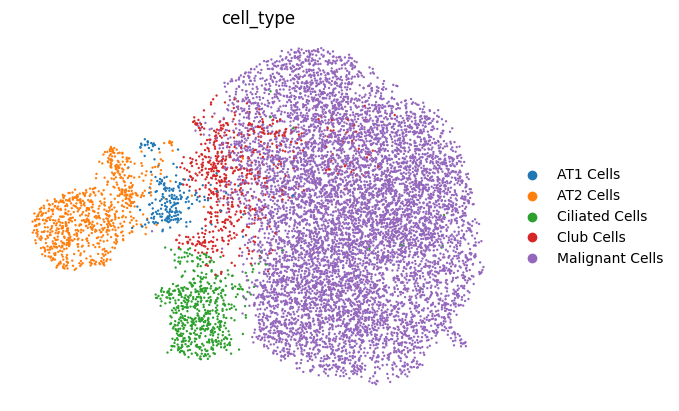

In [60]:
sc.pl.umap(adata, color=['cell_type'], frameon=False, ncols=3)

In [62]:
adata.write("C:/Users/Fabricio S. da Costa/OneDrive/Área de Trabalho/IC/Projetos Singlecell/Atlas Pulmão/Zhang/Epithelium Cells/OBJETO/EpitheliumCells.h5ad", compression="gzip")

In [64]:
vae.save("C:/Users/Fabricio S. da Costa/OneDrive/Área de Trabalho/IC/Projetos Singlecell/Atlas Pulmão/Zhang/OBJETO/scvi_EpitheliumCells.model")

RuntimeError: Parent directory C:/Users/Fabricio S. da Costa/OneDrive/Área de Trabalho/IC/Projetos Singlecell/Atlas Pulmão/Zhang/OBJETO does not exist.